# Contextual bandit

What is the optimal policy for a one-dimensional contextual bandit environment with a bimodal reward-state distribution?

## Define environment

# Hyperparameters: constant

- Standard deviation of normal distributions $\sigma$
- Relative weightings of the two distributions in the mix $p$

### Hyperparameters: variable

- Midpoint between the means of the normal distributions
- Separation between the means of the normal distributions

### Parameters

- Environmental state (feature / context / cue) $s$ (see [Hyperparameters: variable](#hyperparameters-variable))
- Action choice $a$ 
- Probability of a reward $P(r|s,a)$
- Actual reward in a given instance $R(s,a)$

### Implications of single-timestep episodes

- There's no model of the environment because there are no state transitions (and episode initialisations are random)
- Could be considered a *nonstationary* problem because the expected rewards are changing each episode (even though the hyperdistribution from which those expected rewards are sampled is fixed)

In [3]:
# Import libraries
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import norm
import jax.random
from jax.nn import softmax

In [15]:
class BimodalBandit:
    def __init__(self, midpoint, distance, key, sigma=1, p=0.5):
        self.midpoint = midpoint
        self.distance = distance
        self.p = p
        self.sigma = sigma
        self.mu1 = midpoint - distance / 2
        self.mu2 = midpoint + distance / 2
        self.key = key

    def define_reward_probability(self, action):
        reward_probability = self.p * norm.pdf(action, self.mu1, self.sigma) + \
                    (1 - self.p) * norm.pdf(action, self.mu2, self.sigma)
        return reward_probability

    def simulate_reward(self, action):
        self.key, subkey = jax.random.split(self.key)
        reward_probability = self.define_reward_probability(action)
        reward = jax.random.bernoulli(subkey, p=reward_probability).astype(int) 
        # JAX returns booleans, so we convert to int
        return reward

# Set seeds
master_key = jax.random.PRNGKey(0)
master_key, bandit_key = jax.random.split(master_key)

# Set state parameters and bandit environment generator
midpoint = 0
distance = 4
bandit = BimodalBandit(midpoint=midpoint, distance=distance, key=bandit_key) 

# Generate action space and reward probabilities for plotting
action_space = jnp.linspace(-10, 10, 400)
reward_probabilites = jnp.array([bandit.define_reward_probability(action) for action in action_space])
simulated_rewards = jnp.array([bandit.simulate_reward(action) for action in action_space])


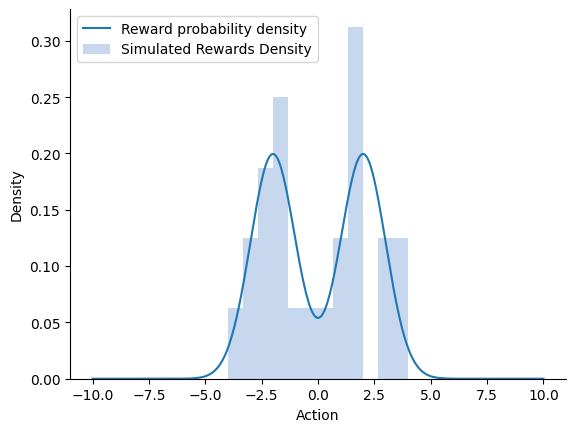

In [19]:
def plot_bimodal_bandit(action_space, reward_probabilites, simulated_rewards):
    fig, ax1 = plt.subplots()
    colors = ['#1f77b4', '#aec7e8']  # Blue color palette

    ax1.set_xlabel('Action')
    ax1.set_ylabel('Density')

    # Plot the PDF
    ax1.plot(action_space, reward_probabilites, color=colors[0], label='Reward probability density')

    # Plot the histogram of simulated rewards with density=True
    ax1.hist(action_space, 
             weights=simulated_rewards, 
             bins=30, alpha=0.7, 
             color=colors[1], 
             density=True, 
             label='Simulated Rewards Density')

    # Add a legend
    ax1.legend()

    # Create L-shaped box
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

# Call the plot_bimodal_bandit function
plot_bimodal_bandit(action_space, reward_probabilites, simulated_rewards)


In [21]:
# Function to select the best action
def select_action(bandit, params, action_space):
    values = jax.vmap(lambda a: -value_function(a, params))(action_space)
    optimal_action_index = jnp.argmax(values)
    return action_space[optimal_action_index]

# Function to update the function approximator parameters
def update_params(params, action, reward, learning_rate=0.01):
    # Simple update rule for illustration
    theta1, theta2, theta3 = params
    theta1_updated = theta1 + learning_rate * reward
    theta2_updated = theta2 + learning_rate * (action - theta2) * reward
    theta3_updated = theta3 + learning_rate * reward
    return jnp.array([theta1_updated, theta2_updated, theta3_updated])

# Value function as before (simple quadratic function for ilustration)
def value_function(action, params):
    theta1, theta2, theta3 = params
    return -(theta1 * (action - theta2)**2 + theta3)

# Initialize bandit and parameters
master_key = jax.random.PRNGKey(0)
_, bandit_key = jax.random.split(master_key)
bandit = BimodalBandit(midpoint=0, distance=4, key=bandit_key, sigma=1, p=0.5)
params = jnp.array([1.0, 0.0, 0.0])  # Initial parameters
action_space = jnp.linspace(-10, 10, 400)  # Discretized action space

# Iterative learning process
for iteration in range(100):
    action = select_action(bandit, params, action_space)
    reward = bandit.simulate_reward(action)
    params = update_params(params, action, reward)
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Action: {action}, Reward: {reward}")

# Final chosen action
final_action = select_action(bandit, params, action_space)
print(f"Final chosen action: {final_action}")

# TODO: exploration behaviour; randomisation to select between actions with tied values

Iteration 0, Action: -10.0, Reward: 0
Iteration 10, Action: -10.0, Reward: 0
Iteration 20, Action: -10.0, Reward: 0
Iteration 30, Action: -10.0, Reward: 0
Iteration 40, Action: -10.0, Reward: 0
Iteration 50, Action: -10.0, Reward: 0
Iteration 60, Action: -10.0, Reward: 0
Iteration 70, Action: -10.0, Reward: 0
Iteration 80, Action: -10.0, Reward: 0
Iteration 90, Action: -10.0, Reward: 0
Final chosen action: -10.0


In [ ]:
# # Value-based action selection
# def greedy_policy(state, action_space, action_values):
#     action_values = jnp.array(action_values)
#     # Select the action with the highest value
#     chosen_action = jnp.argmax(action_space)
#     return chosen_action

# # Policy-based action selection
# # just store the current action probabilities as a vector
# # later, use gradient descent to improve them?
# def explicit_policy(state, action_space):
#     action_proba
#     return chosen_action

# # Modify the policy to include exploration
# epilon_greedy(action_probabilities, epsilon=0.1, exploration_method="random", exploration_range=[-10, 10]):
#     if exploration_method == "random":
#         # select action according to uniform distribution in exploration_range
#     else:
#         # select action according to action_probabilities
#     return modified_action_probabilities

In [38]:
# def epsilon_greedy_policy(bandit, epsilon, num_action=10):
#     key = bandit.key
#     # Split the key for generating random action
#     key, subkey = jax.random.split(key)
    
#     # Assuming action_values are from -10 to 10, normalize this range to select action
#     action_space = jnp.linspace(-10, 10, num_action)
    
#     # Generate a random number to decide on exploration vs exploitation
#     rnd = jax.random.uniform(subkey)
#     if rnd < epsilon:
#         # Exploration: Select a random action
#         action_idx = jax.random.randint(subkey, (1,), 0, num_action)
#         chosen_action = action_space[action_idx[0]]
#     else:
#         # Exploitation: This requires having a model to estimate the best action.
#         # For simplicity, let's randomly select an action as a placeholder for actual exploitation logic.
#         # In a real scenario, you would use historical rewards or a model to determine the best action.
#         action_idx = jax.random.randint(subkey, (1,), 0, num_action)
#         chosen_action = action_space[action_idx[0]]

#     # Update the bandit's key
#     bandit.key = key
    
#     # Simulate the reward for the chosen action
#     reward = bandit.simulate_reward(chosen_action)
#     return chosen_action, reward

# # Example of using the policy
# epsilon = 0.1  # 10% of the time explore
# chosen_action, reward = epsilon_greedy_policy(bandit, epsilon, num_action=10)
# print(f"Chosen action: {chosen_action}, Reward: {reward}")


Chosen action: 3.333333969116211, Reward: 0


In [ ]:
# def update_policy_based(preferences, action, reward, learning_rate=0.1):
#     policy = softmax(preferences)
#     # Gradient of log policy
#     grad_log_policy = -policy
#     grad_log_policy = jax.ops.index_add(grad_log_policy, action, 1.0 - policy[action])
#     # Update preferences
#     updated_preferences = preferences + learning_rate * reward * grad_log_policy
#     return updated_preferences

# def select_action_policy_based(preferences, key):
#     policy = softmax_preferences(preferences)
#     return jax.random.choice(key, len(preferences), p=policy)


## TODO

### Define policy
- Inputs: state $s$
- Outputs: action $a$

### Generate reward samples 
- Generate action according to the policy
- Sample rewards from those action

### Estimate value of action
- Since each episode is one timestep, total return = reward at $t{0}$

### Update the policy 
- RL: gradient descent (batch size = full sample)
- EA: geometric mean?
- Minimax: regret

How should the EA and minimax updates be calculated?

### Action effects on environment (full MDP)
- Transition (environmental feedback) dynamics $P(s'|a,s)$
- Discount rate $\gamma$